In [1]:
import numpy as np
import pandas
from pathlib import Path
import allel
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# replace this with wherever you have files downloaded and unzipped to
input_dir = Path('/kwiat/vector/observatory/analysis/107-sfs-data-request-imperial')

In [3]:
!ls -lh {input_dir} | grep csv

-rw-r--r-- 1 aliman aliman 6.9M May 29 16:50 BFcol.3L.csv
-rw-r--r-- 1 aliman aliman  11M May 29 16:50 BFcol.3R.csv
-rw-r--r-- 1 aliman aliman 8.1M May 29 16:50 BFgam.3L.csv
-rw-r--r-- 1 aliman aliman  13M May 29 16:49 BFgam.3R.csv
-rw-r--r-- 1 aliman aliman 1.5M May 29 16:51 KE.3L.csv
-rw-r--r-- 1 aliman aliman 2.2M May 29 16:51 KE.3R.csv


In [4]:
# choose a chromosome and population to analyse
seqid = '3R'
pop = 'BFcol'  # Burkina Faso An. coluzzii

In [5]:
# read data into a data frame
df = pandas.read_csv(input_dir / '{pop}.{seqid}.csv'.format(pop=pop, seqid=seqid))
df.head()

,POS,REF,ALT,EPIR,CHRI,MERU,MELA,QUAD,ARAB,CODON_POS,CODON_DEG,REF_AC,ALT_AC
0,14997,C,T,C,C,C,C,C,C,2,3,149,1
1,15060,G,A,G,G,G,G,G,G,2,2,149,1
2,15087,C,T,C,C,C,C,C,C,2,2,133,17
3,15098,G,A,G,G,A,G,G,G,0,3,146,4
4,15198,G,A,G,T,G,G,G,G,2,4,148,2


In [6]:
len(df)

316101

In [7]:
# N.B., values in the CODON_DEG column have special meaning:
DEG_0 = 1  # means 0-fold degenerage
DEG_2_SIMPLE = 2  # means simple 2-fold degenerate
DEG_2_COMPLEX = 3  # means complex 2-fold degenerate
DEG_4 = 4  # means 4-fold degenerate

In [8]:
# extract allele counts for analysis via scikit-allel
ac = np.column_stack([df['REF_AC'], df['ALT_AC']])
ac

array([[149,   1],
       [149,   1],
       [133,  17],
       ..., 
       [  1, 149],
       [149,   1],
       [142,   8]])

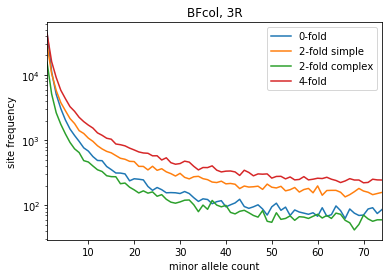

In [9]:
# calculate folded SFS and visualise

fig, ax = plt.subplots()

for deg, lbl in zip([DEG_0, DEG_2_SIMPLE, DEG_2_COMPLEX, DEG_4],
                    ['0-fold', '2-fold simple', '2-fold complex', '4-fold']):
    loc = df['CODON_DEG'] == deg
    sfs = allel.sfs_folded(ac[loc])
    allel.plot_sfs_folded(sfs, ax=ax, label=lbl)

ax.set_title('{pop}, {seqid}'.format(pop=pop, seqid=seqid))
ax.legend();

In [10]:
# locate sites where we can polarise against consensus of merus and melas
loc_outgroup_ascertained = (
    # require an allele to be called
    (df.MERU != 'N') & 
    # require consensus between outgroups
    (df.MERU == df.MELA) & 
    # require the outgroup allele to match one of the ingroup alleles
    ((df.MERU == df.REF) | (df.MERU == df.ALT))
) 
np.count_nonzero(loc_outgroup_ascertained)

269623

In [11]:
# build a new dataframe augmented with polarised allele counts
df_polar = df.loc[loc_outgroup_ascertained].copy()
df_polar.head()

,POS,REF,ALT,EPIR,CHRI,MERU,MELA,QUAD,ARAB,CODON_POS,CODON_DEG,REF_AC,ALT_AC
0,14997,C,T,C,C,C,C,C,C,2,3,149,1
1,15060,G,A,G,G,G,G,G,G,2,2,149,1
2,15087,C,T,C,C,C,C,C,C,2,2,133,17
4,15198,G,A,G,T,G,G,G,G,2,4,148,2
5,15318,G,A,G,T,G,G,G,G,2,4,142,8


In [12]:
len(df_polar)

269623

In [13]:
# add columns for ancestral and derived allele counts
df_polar['ANC_AC'] = np.where(df_polar.REF == df_polar.MERU, df_polar.REF_AC, df_polar.ALT_AC)
df_polar['DER_AC'] = np.where(df_polar.REF == df_polar.MERU, df_polar.ALT_AC, df_polar.REF_AC)
df_polar.head()

,POS,REF,ALT,EPIR,CHRI,MERU,MELA,QUAD,ARAB,CODON_POS,CODON_DEG,REF_AC,ALT_AC,ANC_AC,DER_AC
0,14997,C,T,C,C,C,C,C,C,2,3,149,1,149,1
1,15060,G,A,G,G,G,G,G,G,2,2,149,1,149,1
2,15087,C,T,C,C,C,C,C,C,2,2,133,17,133,17
4,15198,G,A,G,T,G,G,G,G,2,4,148,2,148,2
5,15318,G,A,G,T,G,G,G,G,2,4,142,8,142,8


In [14]:
df_polar.tail()

,POS,REF,ALT,EPIR,CHRI,MERU,MELA,QUAD,ARAB,CODON_POS,CODON_DEG,REF_AC,ALT_AC,ANC_AC,DER_AC
316096,53093362,A,G,A,C,A,A,A,A,2,4,147,3,147,3
316097,53093536,C,T,C,C,C,C,C,C,2,2,149,1,149,1
316098,53093587,T,C,C,C,C,C,C,C,2,2,1,149,149,1
316099,53093754,G,A,G,G,G,G,G,G,0,1,149,1,149,1
316100,53093904,T,C,T,T,T,T,T,T,0,3,142,8,142,8


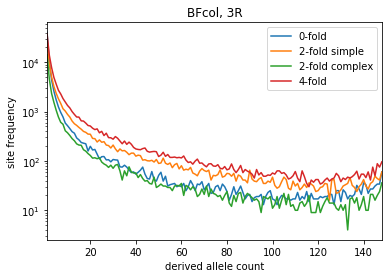

In [15]:
# calculate unfolded SFS and visualise

fig, ax = plt.subplots()
dac = df_polar.DER_AC.values

for deg, lbl in zip([DEG_0, DEG_2_SIMPLE, DEG_2_COMPLEX, DEG_4],
                    ['0-fold', '2-fold simple', '2-fold complex', '4-fold']):
    loc = df_polar['CODON_DEG'] == deg
    sfs = allel.sfs(dac[loc])
    allel.plot_sfs(sfs, ax=ax, label=lbl)

ax.set_title('{pop}, {seqid}'.format(pop=pop, seqid=seqid))
ax.legend();